# Deep Neural Net with L2 Regularization

Creating a variable-layer neural network from memory as a learning exercise.

Uses the cat v non-cat dataset from the [coursera course](https://www.coursera.org/specializations/deep-learning) on Deep Learning by Andrew Ng.

Hyperparameters are number of layers and hidden units, lambda for L2 regularisation, learning rate alpha and number of epochs.

## Import Libraries

In [100]:
# import libraries
import numpy as np
import h5py
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles, make_moons, make_classification
import time


# load data
train_data = h5py.File('C:/Users/leahy/Google Drive/Freelance/own_projects/ml_from_scratch/datasets/train_catvnoncat.h5', 'r')
test_data = h5py.File('C:/Users/leahy/Google Drive/Freelance/own_projects/ml_from_scratch/datasets/test_catvnoncat.h5', 'r')
X_train = np.array(train_data['train_set_x'])
y_train = np.array(train_data['train_set_y'])
X_test = np.array(test_data['test_set_x'])
y_test = np.array(test_data['test_set_y'])

# X_train and X_test contain samples of [m, 64, 64, 3], representing image
# hight x width x RGB channels. Reshape to be single vector of size
# n * m. Also rescale by 255
X_train = X_train.reshape(X_train.shape[0], -1).T / 255
X_test = X_test.reshape(X_test.shape[0], -1).T / 255

# reshape the y's
y_train = y_train.reshape(1, len(y_train))
y_test = y_test.reshape(1, len(y_test))

## Set up Functions

In [101]:
def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))
    return A

def initialise_params(layer_dims):
    init_params = dict()
    L = len(layer_dims)
    for i in range(1, L):
        cur_n = layer_dims[i]
        # set W initial weights to be the square root of nodes in prev. layer
        # ie using "He 2012" initialisiation
        init_params["W" + str(i)] = np.random.randn(
            layer_dims[i], layer_dims[i - 1]) *\
                (np.sqrt(2 / layer_dims[i - 1]))
        init_params["b" + str(i)] = np.zeros([layer_dims[i], 1])
    
        assert(init_params['W' + str(i)].shape == (
            layer_dims[i], layer_dims[i - 1]))
        assert(init_params['b' + str(i)].shape == (layer_dims[i], 1))
    return init_params


def forward_prop(X, params):
    L = len(params) // 2
    m = X.shape [1]
    preds = {}
    preds['A0'] = X
    A_prev = X
    # For layers 1:L-1 we use relu
    for i in range(1, L):
        W = params['W' + str(i)]
        b = params['b' + str(i)]
        Z = np.dot(W, A_prev) + b
        A = np.maximum(0, Z)
        
        preds['Z' + str(i)] = Z
        preds['A' + str(i)] = A

        assert(preds['Z' + str(i)].shape == (layer_dims[i], m))
        assert(preds['A' + str(i)].shape == (layer_dims[i], m))
        
        A_prev = A

    # For final layer use sigmoid
    W = params['W' + str(L)]
    b = params['b' + str(L)]
    Z = np.dot(W, A_prev) + b
    A = sigmoid(Z)
    
    preds['Z' + str(L)] = Z
    preds['A' + str(L)] = A
    
    assert(preds['Z' + str(L)].shape == (layer_dims[L], m))
    assert(preds['A' + str(L)].shape == (layer_dims[L], m))
    
    return preds


def compute_cost(AL, y, params, l2_lambda=None):
    m = y.shape[1]
    L = len(params) // 2
        
    log_probs = np.multiply(y, -np.log(AL)) + np.multiply(
        (1 - y), -np.log(1 - AL))
    cost = np.nansum(log_probs) / m

    # calc L2 reg cost
    reg_term = 0
    for i in range(1, L + 1):
        W = params['W' + str(i)]
        #  we divide by 2m simply by convention so that the derivative
        # constant in backprop is lambda/m rather than 2 * lambda/m
        reg_term += (l2_lambda / (2 * m)) * (np.linalg.norm(W, ord='fro'))

    cost += reg_term

    assert cost.shape == ()
    
    return cost


def back_prop(y, preds, params, l2_lambda=None):
    L = len(params) // 2
    grads = {}
    m = y.shape[1]

    for i in reversed(range(1, L + 1)):
        if i == L:
            # for final case, dLdZL = dLdAL*dALdZL = AL - y
            AL = preds['A' + str(L)]
            dZ = AL - y
        else:
            # for other cases
            # _plus represent values at i + 1
            dZ_plus = grads['dZ' + str(i + 1)]
            W_plus = params['W' + str(i + 1)]
            Z = preds['Z' + str(i)]
            # gradient of relu fn
            relu_grad = np.zeros(Z.shape)
            relu_grad[Z > 0] = 1
            dZ = np.dot(W_plus.T, dZ_plus) * relu_grad
        
        grads['dZ' + str(i)] = dZ
        
        A_prev = preds['A' + str(i - 1)]
        
        # including L2 regularization!
        W = params['W' + str(i)]
        grads['dW' + str(i)] = (np.dot(dZ, A_prev.T) + (l2_lambda * W)) / m
        grads['db' + str(i)] = np.sum(dZ, axis=1, keepdims=True) / m
        
    return grads


def update_params(grads, params, alpha):
    L = len(params) // 2
    for i in range(1, L + 1):
        params['W' + str(i)] -= (alpha * grads['dW' + str(i)])
        params['b' + str(i)] -= (alpha * grads['db' + str(i)])
        
    return params


def fit(X, y, layer_dims, num_iterations, alpha, l2_lambda=None,
        cost_interval=200):
    params = initialise_params(layer_dims)
    L = len(params) // 2
    costs = []
    for i in range(num_iterations):
        preds = forward_prop(X, params)
        J = compute_cost(preds['A' + str(L)], y, params, l2_lambda)
        if i % cost_interval == 0:
            print(f'cost after iter {i}: {J}')
        if i % 100 == 0:
            costs += [J]
        grads = back_prop(y, preds, params, l2_lambda)
        params = update_params(grads, params, alpha)
        
    plt.plot(costs)
    plt.show()
    return params, costs

def predict(X, params):
    L = len(params) // 2
    preds = forward_prop(X, params)
    y_pred = preds['A' + str(L)]
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0
    return y_pred


def accuracy_score(y_test, y_pred):
    m = y_test.shape[1]
    score = np.sum(y_test == y_pred) / m
    print(f'accuracy: {score}')
    return score
        

## Fit, Predict, Score

Let's see effects of regularisation

lambda=0
cost after iter 0: 0.7095350929383001
cost after iter 200: 0.5531215775179099
cost after iter 400: 0.20616499168258476
cost after iter 600: 0.3972160327329145
cost after iter 800: 0.04453866422900078
cost after iter 1000: 0.019518166851579973
cost after iter 1200: 0.011426204115048692
cost after iter 1400: 0.00766872922979565
cost after iter 1600: 0.005609708390514454
cost after iter 1800: 0.0043353010112505185
cost after iter 2000: 0.003490820023837182
cost after iter 2200: 0.002898564319892692


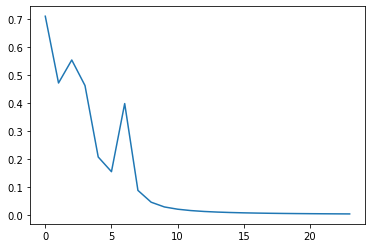

Train set:
accuracy: 1.0
Test Set:
accuracy: 0.72
took 42.47967529296875 seconds


lambda=0.001
cost after iter 0: 0.7167000400948975
cost after iter 200: 0.542840414784643
cost after iter 400: 0.4283448245457164
cost after iter 600: 0.3103674353245235
cost after iter 800: 0.12612176897562521
cost after iter 1000: 0.049329710445128586
cost after iter 1200: 0.02068344396949862
cost after iter 1400: 0.01204235353584038
cost after iter 1600: 0.0080872037882747
cost after iter 1800: 0.005902712843186399
cost after iter 2000: 0.004562085184142841
cost after iter 2200: 0.0036763618888465627


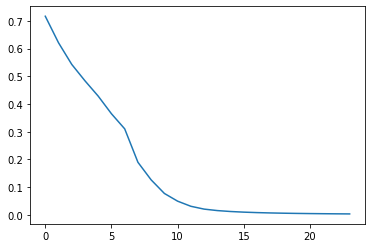

Train set:
accuracy: 1.0
Test Set:
accuracy: 0.7
took 36.07852053642273 seconds


lambda=0.01
cost after iter 0: 0.6791798599988482
cost after iter 200: 0.4294197808564114
cost after iter 400: 0.2686086231309208
cost after iter 600: 0.09628875219808145
cost after iter 800: 0.03728987608693348
cost after iter 1000: 0.0182768342707358
cost after iter 1200: 0.011562224275459934
cost after iter 1400: 0.008213025327934977
cost after iter 1600: 0.006259425816006024
cost after iter 1800: 0.005010924886780197
cost after iter 2000: 0.004155486964256444
cost after iter 2200: 0.0035424934716190653


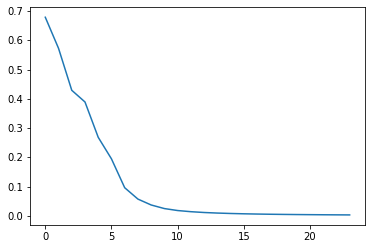

Train set:
accuracy: 1.0
Test Set:
accuracy: 0.68
took 49.13385081291199 seconds




In [102]:
layer_dims = [X_train.shape[0], 20, 7, 5, y_train.shape[0]]
num_iterations = 2400
alpha = .0075
l2_lambdas = [0, 0.001, 0.01]
# interval in the iterations for which the costs will be stored
cost_interval = 200

for l2_lambda in l2_lambdas:
    start = time.time()
    
    print(f'lambda={l2_lambda}')
    params, costs = fit(X_train, y_train, layer_dims, num_iterations, alpha,
                        l2_lambda, cost_interval)
    y_pred_train = predict(X_train, params)
    y_pred_test = predict(X_test, params)

    print('Train set:')
    accuracy_score(y_train, y_pred_train)

    print('Test Set:')
    accuracy_score(y_test, y_pred_test)
    
    end = time.time()
    print(f'took {end - start} seconds\n\n')

## Performance on generated dataset

In [121]:
m = 2000
# data = make_classification(n_features=2, n_redundant=0, n_informative=2,
#                            n_clusters_per_class=2, n_samples=m)
# data = make_circles(n_samples=m, factor=.5, noise=.03)

data = make_moons(n_samples=m, noise=.25)


X, y = data[0].T, data[1].reshape(1, -1)

idx = np.arange(X.shape[1])
np.random.shuffle(idx)

X_train = X[:, idx[0:int(m * .8)]]
X_test = X[:, idx[int(m * .8):]]
y_train = y[:, idx[0:int(m * .8)]]
y_test = y[:, idx[int(m * .8):]]

lambda=0
cost after iter 0: 0.7322637045312831


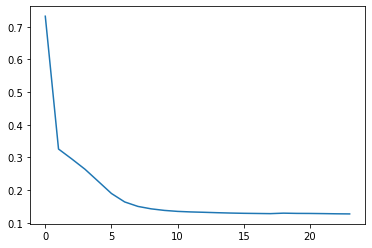

Train set:
accuracy: 0.946875
Test Set:
accuracy: 0.94
took 4.786148548126221 seconds


lambda=0.001
cost after iter 0: 0.6313815503597857


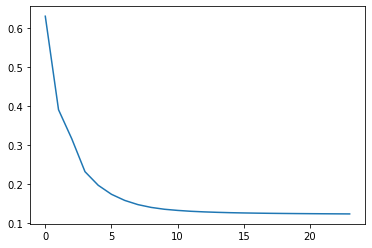

Train set:
accuracy: 0.944375
Test Set:
accuracy: 0.9375
took 5.682788610458374 seconds


lambda=0.01
cost after iter 0: 1.0056345259838433


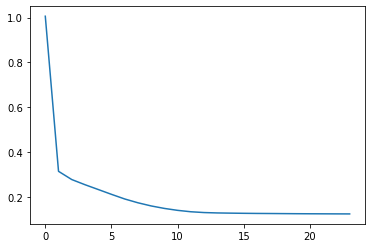

Train set:
accuracy: 0.946875
Test Set:
accuracy: 0.945
took 6.017758369445801 seconds


lambda=0.1
cost after iter 0: 0.8538221970264084


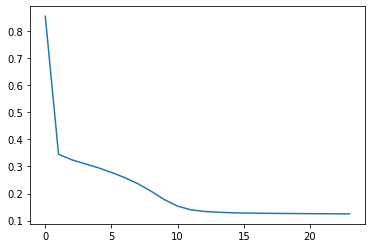

Train set:
accuracy: 0.94875
Test Set:
accuracy: 0.9375
took 6.237306356430054 seconds




In [123]:
layer_dims = [X_train.shape[0], 20, 7, 5, y_train.shape[0]]
num_iterations = 2400
alpha = .075
l2_lambdas = [0, 0.001, 0.01, .1]
# interval in the iterations for which the costs will be stored
cost_interval = 20000000
np.random.seed(1)
for l2_lambda in l2_lambdas:
    start = time.time()
    
    print(f'lambda={l2_lambda}')
    params, costs = fit(X_train, y_train, layer_dims, num_iterations, alpha,
                        l2_lambda, cost_interval)
    y_pred_train = predict(X_train, params)
    y_pred_test = predict(X_test, params)

    print('Train set:')
    accuracy_score(y_train, y_pred_train)

    print('Test Set:')
    accuracy_score(y_test, y_pred_test)
    
    end = time.time()
    print(f'took {end - start} seconds\n\n')

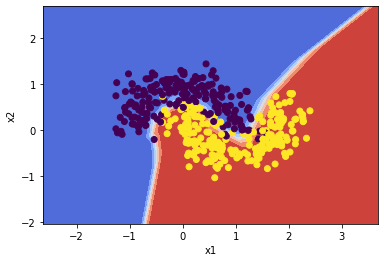

In [131]:
# Set min and max values for meshgrid
x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1

# Generate a grid of points with distance h between them
h = 0.01
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Predict the function value for the whole grid using previous params
L = len(params) // 2
X_mesh = np.c_[xx.ravel(), yy.ravel()].T
Z = forward_prop(X_mesh, params)['A' + str(L)]
Z = Z.reshape(xx.shape)

# Plot the contour and training examples
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm)
plt.ylabel('x2')
plt.xlabel('x1')
plt.scatter(X_test[0, :], X_test[1, :], c=np.squeeze(y_test))